In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmap

import plotly.express as px
import plotly.graph_objects as go

In [88]:
wapo = pd.read_csv('data/fatal-police-shootings-data.csv')
display(wapo.head())
display(wapo.count())

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


id                         5740
name                       5524
date                       5740
manner_of_death            5740
armed                      5527
age                        5479
gender                     5739
race                       5123
city                       5740
state                      5740
signs_of_mental_illness    5740
threat_level               5740
flee                       5446
body_camera                5740
longitude                  5458
latitude                   5458
is_geocoding_exact         5740
dtype: int64

Looks like we have some missing values throughout this dataset. Depending on our analysis, we may need to drop rows that have missing values.

In order to normalize police shootings in a given state, we have to take the total population of that state into account. I downloaded a dataset (state-populations-est2019.csv) from https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

In the cell below, I need to convert state names to state abbreviations using a dictionary. I then create a US state choropleth map of the number of shootings per 1 million people. On top of this map, I overlay the police shootings based on geolocation from the Washington Post's Police shootings database.

In [105]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_totals = wapo['state'].value_counts().sort_index()

state_populations = pd.read_csv('data/state-populations-est2019.csv')
state_populations = state_populations[['NAME', 'POPESTIMATE2019']].iloc[5:56,:]
state_populations.NAME = [us_state_abbrev[key] for key in list(state_populations.NAME)]
state_populations = state_populations.sort_values(by=['NAME'])

fig = px.choropleth(locations=state_totals.index, 
                    locationmode="USA-states", 
                    color=round((state_totals.values / state_populations.POPESTIMATE2019) * 1000000), 
                    scope="usa", 
                    color_continuous_scale = ['#f5f5f5', '#bbb'])

scatter = go.Figure(data=go.Scattergeo(
        lon = wapo['longitude'],
        lat = wapo['latitude'],
        mode = 'markers',
        marker=dict(opacity=0.2, size=4, line=dict(color='#f26414', width=2))
        ))

fig.add_trace(scatter.data[0])

fig.update_layout(
        margin={"r":0,"t":100,"l":0,"b":20},
        title={
            'text': "Each circle on the map below marks the location of a deadly shooting",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        font_family="Georgia",
        font_color="#000",
        coloraxis_colorbar=dict(
            title="Shootings per million people"
        )
    )

fig.update_traces(marker_line_width=0.3)
config = {'staticPlot': True}
fig.show(config=config)

**Figure 1.** A simple recreation of the [Washington Post Police shootings map](https://www.washingtonpost.com/graphics/investigations/police-shootings-database/). More opaque clusters indicate hotspots of police shootings. States that are darker have more shootings per million people.


*Note:* I disabled interactivity on this map. Again, if our analysis requires it, I can renable it. I think this will serve as a good base for future maps we want to create.

<hr>

We wanted to also look at how police use of force policies relates to police violence.

As outlined on http://useofforceproject.org/#review, the use of force policies are:

1. Requires De-Escalation
2. Has Use of Force Continuum
3. Bans Chokeholds and Strangleholds
4. Requires Warning Before Shooting
5. Restricts Shooting at Moving Vehicles
6. Requires Exhaust All Other Means Before Shooting
7. Duty to Intervene
8. Requires Comprehensive Reporting

They have also generated a dataset of use of force policies of America's 100 largest city police departments which we will use. In the cell below, I collapse the Washington Post police dataset by city to attain the number of police shootings per city (including special processing for Kansas City, MO and Washington, DC since these city names do not match those in the use of force dataset). I normalize the shootings based on city population included in the use of force dataset, sort the values, and use a bar plot to display them.

Text(0.5, 1.0, 'Rate of police shootings by 100 largest police departments')

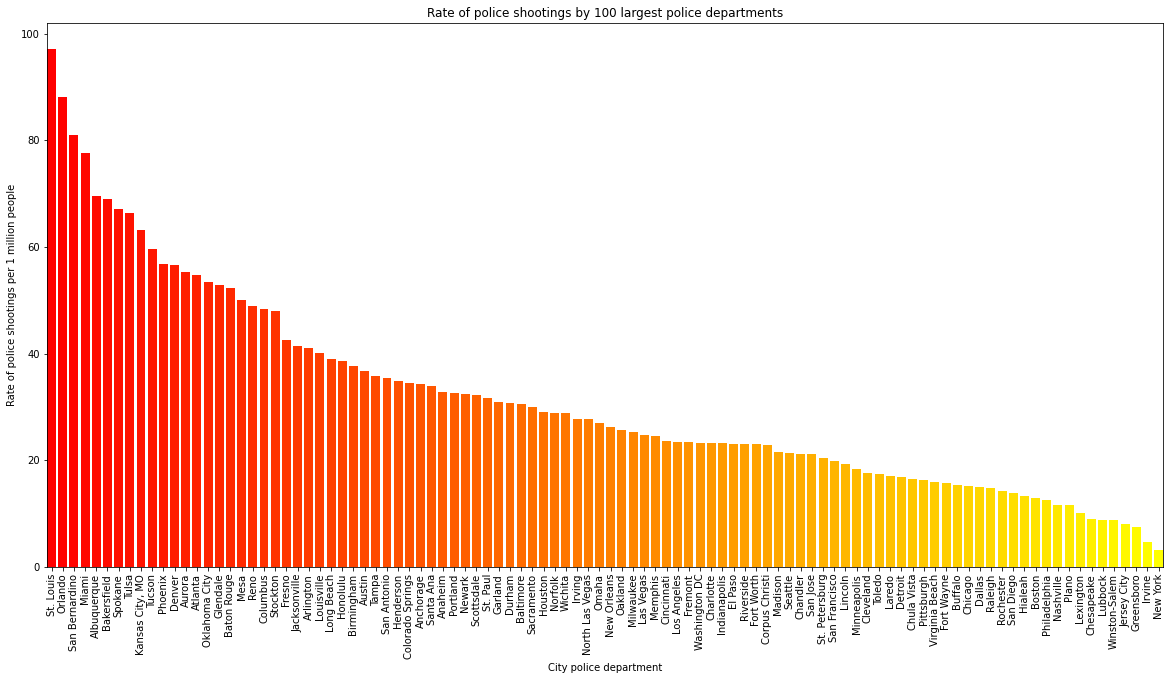

In [107]:
pd_100_shootings = {}

for city in use_of_force['Police Department'].values:
    if city in wapo.groupby('city').size().index:
        pd_100_shootings[city] = (wapo.groupby('city').size()[city])
    elif city in (wapo['city']+ ', '+ wapo['state']).values:
        pd_100_shootings[city] = (len(wapo[(wapo['city']+ ', '+ wapo['state']) == city]))
    elif city in (wapo['city']+ ' '+ wapo['state']).values:
         pd_100_shootings[city] = (len(wapo[(wapo['city']+ ' '+ wapo['state']) == city]))
            
use_of_force = pd.read_csv('data/use-of-force.csv')
use_of_force = use_of_force.join(pd.DataFrame(pd_100_shootings.values(), index=pd_100_shootings.keys(), columns=['Number of shootings']), on='Police Department')
use_of_force['shootings per 1M'] = (use_of_force['Number of shootings']/use_of_force['Total Population'])*1000000
use_of_force = use_of_force.sort_values(by=['shootings per 1M'], ascending=False)

plt.figure(figsize=(20,10))
plt.bar(use_of_force['Police Department'], use_of_force['shootings per 1M'], color = cmap.autumn(np.linspace(0, 1, len(use_of_force))))
plt.margins(x=0)
plt.xticks(rotation='vertical')
plt.xlabel('City police department')
plt.ylabel('Rate of police shootings per 1 million people')
plt.title('Rate of police shootings by 100 largest police departments')

# use_of_force['Number of shootings']

**Figure 2.**

I think it would be interesting to see how these relate...

In [147]:
largest_100_perc_shootings = (use_of_force['Number of shootings'].sum() / len(wapo))*100
print(f'The largest 100 city police department shootings account for {round(largest_100_perc_shootings,3)}% of all police shootings recorded since 2015.')

num_cities = wapo['city'].value_counts()
print(f'{len(num_cities)} cities are recorded as having at least 1 police shooting in the Washington Post dataset.')

The largest 100 city police department shootings account for 28.24% of all police shootings recorded since 2015.
2573 cities are recorded as having at least 1 police shooting in the Washington Post dataset.


<AxesSubplot:>

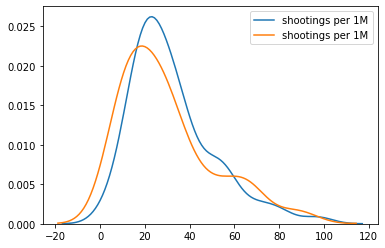

In [177]:
policy = 'Has Use of Force Continuum'

policy_yes = use_of_force[use_of_force[policy] == 1]['shootings per 1M']
policy_no = use_of_force[use_of_force[policy] == 0]['shootings per 1M']

sns.kdeplot(policy_yes)
sns.kdeplot(policy_no)
# longitudinal: how have police shootings in these cities changed over time;

# when were these policies implemented? and did that have any affect on the rate of shootings

In [186]:
use_of_force['# of policies'] = use_of_force.iloc[:, 1:17].sum(axis=1)


(array([7., 6., 7., 5., 1., 2., 1., 2., 0., 1.]),
 array([ 7.41658199, 15.48734511, 23.55810823, 31.62887135, 39.69963447,
        47.77039759, 55.8411607 , 63.91192382, 71.98268694, 80.05345006,
        88.12421318]),
 <BarContainer object of 10 artists>)

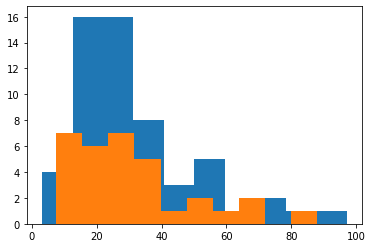

In [199]:
plt.hist(use_of_force[use_of_force['# of policies'] > 4]['shootings per 1M'])
plt.hist(use_of_force[use_of_force['# of policies'] < 4]['shootings per 1M'])